In [1]:
# coding: utf-8
import sys
sys.path.insert(0,"/home/xlwang/NetworkCompress/src")

import os
os.environ["KERAS_BACKEND"]="theano"
# os.environ["KERAS_IMAGE_DIM_ORDERING"]="tf"
import keras
from keras import backend as K
K.set_image_dim_ordering('th')
print keras.backend.image_dim_ordering()
# print keras.backend.image_data_format()


Using Theano backend.
Using gpu device 0: Quadro M5000 (CNMeM is enabled with initial size: 1.0% of memory, cuDNN 5110)
/usr/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


th


In [2]:

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

from net2net import *
input_shape=(1,2,2)
%matplotlib inline
def make_model_for_conv_fc(width,with_activation=False,with_max_pool=False,with_dropout=False):
    input_node=Input(shape=(input_shape),name="input")
    x=Convolution2D(width,1,1,name='conv8',border_mode="same"
                    ,activation='relu'if  with_activation else None
                    )(input_node)
    x=MaxPooling2D(name="pool1")(x)  if with_max_pool else x
    x=Dropout(0.25,name="drop1")(x) if with_dropout else x
    x=Flatten(name="flatten")(x)
    output_node=Dense(4,name='fc1'
            ,activation='relu'if  with_activation else None
            )(x)
    model=Model(input=input_node,output=output_node)
    model.trainable=False
    return model
np.random.seed(1)
input_inst=np.random.random((1,)+input_shape)


init


/usr/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


reload
using keras backend theano
using gpu

------------------------------



In [3]:
model=make_model_for_conv_fc(2)
model2=make_model_for_conv_fc(4)
ln=np.array([l.name for l in model.layers])[[1,3]]
lw=np.array([l.get_weights() for l in model.layers ])[[1,3]]
pprint([ (a,b[0].shape,b[1].shape) for a,b in  zip(ln,lw) ])
pprint(zip(ln,lw)) 

conv8_inst=K.function(inputs=[model.input,K.learning_phase()],outputs=[model.get_layer("conv8").output])([input_inst,0])[0]
print conv8_inst,conv8_inst.shape

flatten_inst=K.function(inputs=[model.input,K.learning_phase()],outputs=[model.get_layer("flatten").output])([input_inst,0])[0]
print flatten_inst,flatten_inst.shape

fc1_inst=K.function(inputs=[model.input,K.learning_phase()],outputs=[model.get_layer("fc1").output])([input_inst,0])[0]
print fc1_inst,fc1_inst.shape

[('conv8', (2, 1, 1, 1), (2,)), ('fc1', (8, 4), (4,))]
[('conv8',
  [array([[[[-0.99912524]]],


       [[[-1.15304053]]]], dtype=float32),
   array([ 0.,  0.], dtype=float32)]),
 ('fc1',
  [array([[-0.44369507, -0.21841012, -0.14599285,  0.05489515],
       [-0.11427622,  0.26193994, -0.41796765,  0.53473878],
       [-0.6683749 ,  0.24107747, -0.11694867,  0.08299995],
       [-0.50856966, -0.42694896,  0.42531705,  0.66222185],
       [-0.26385805,  0.27198526,  0.53229463,  0.55805808],
       [-0.5868361 , -0.65187496, -0.4669303 ,  0.53477424],
       [-0.56802338, -0.11157066,  0.64755356,  0.04690279],
       [ 0.27135521, -0.26090029,  0.26375213,  0.47323215]], dtype=float32),
   array([ 0.,  0.,  0.,  0.], dtype=float32)])]
[[[[ -4.16657209e-01  -7.19694436e-01]
   [ -1.14274764e-04  -3.02068114e-01]]

  [[ -4.80843246e-01  -8.30563366e-01]
   [ -1.31878798e-04  -3.48601729e-01]]]] (1, 2, 2, 2)
[[ -4.16657209e-01  -7.19694436e-01  -1.14274764e-04  -3.02068114e-01
   -4.80843

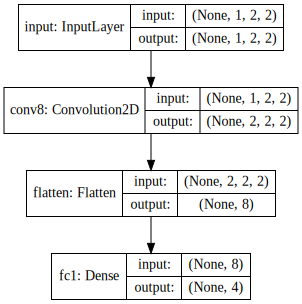

In [4]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

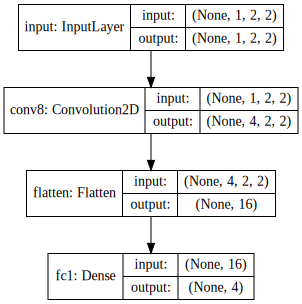

In [5]:
SVG(model_to_dot(model2,show_shapes=True).create(prog='dot', format='svg'))

In [6]:
copy_weights(teacher_model=model,student_model=model2)
copy_weights(student_model=model2,teacher_model=model)

w_conv1, b_conv1 = model.get_layer("conv8").get_weights()
w_conv2, b_conv2 = model.get_layer("fc1").get_weights()
# new_w_conv1, new_b_conv1, new_w_conv2 = wider_conv2d_weight(
#     w_conv1, b_conv1, w_conv2, 256, "net2wider")
new_w_conv1=np.concatenate([w_conv1,w_conv1],axis=0)
new_b_conv1=np.concatenate([b_conv1,b_conv1],axis=0)

new_w_conv2=np.concatenate([w_conv2/2,w_conv2/2],axis=0)

model2.get_layer("conv8").set_weights([new_w_conv1, new_b_conv1])
model2.get_layer("fc1").set_weights([new_w_conv2, b_conv2])


In [7]:
output_inst=K.function(inputs=[model.input, K.learning_phase()], outputs=[model.output])([input_inst,0])[0]

output_inst2=K.function(inputs=[model2.input, K.learning_phase()], outputs=[model2.output])([input_inst,0])[0]
print output_inst,'\n',output_inst2

[[ 0.94057065  0.53303176  0.27301165 -1.48524463]] 
[[ 0.94057059  0.53303176  0.27301165 -1.48524451]]


In [8]:
from net2net import *
input_shape=(3,16,16)

def make_model_for_conv_fc(width,with_activation=False,with_max_pool=False,with_dropout=False):
    input_node=Input(shape=(input_shape),name="input")
    x=Convolution2D(width,3,3,name='conv8',border_mode="same"
                    ,activation='relu'if  with_activation else None
                    )(input_node)
    x=MaxPooling2D(name="pool1")(x)  if with_max_pool else x
    x=Dropout(0.25,name="drop1")(x) if with_dropout else x
    x=Flatten(name="flatten")(x)
    output_node=Dense(2048,name='fc1'
            ,activation='relu'if  with_activation else None
            )(x)
    model=Model(input=input_node,output=output_node)
    model.trainable=False
    return model
np.random.seed(1)
input_inst=np.random.random((1,)+input_shape)
new_width=128
model=make_model_for_conv_fc(64)
model2=make_model_for_conv_fc(new_width)

copy_weights(teacher_model=model,student_model=model2)

w_conv8, b_conv8 = model.get_layer("conv8").get_weights()
w_fc1, b_fc1 = model.get_layer("fc1").get_weights()

# new_w_conv1, new_b_conv1, new_w_conv2 = wider_conv2d_weight(
#     w_conv1, b_conv1, w_conv2, 256, "net2wider")

n= new_width - w_conv8.shape[0]
index=np.random.randint(w_conv8.shape[0], size=n)
factors=np.bincount(index)[index]+1
new_w1=w_conv8[index, ...]
noise=np.random.normal(0,5e-2*new_w1.std(),size=new_w1.shape)
new_w_conv1=np.concatenate([w_conv8, new_w1 + noise], axis=0)
new_b1=b_conv8[index]
noise=np.random.normal(0,5e-2*new_b1.std(),size=new_b1.shape)
new_b_conv1=np.concatenate([b_conv8, new_b1 + noise], axis=0)

index_fc = np.empty(shape=[0, ], dtype=int)
factor_fc = np.empty(shape=[0, ], dtype=int)
for i, j in zip(index.reshape((-1,)), factors.reshape((-1,))):
    start = i * 256
    end = (i + 1) * 256
    #     print index_fc.shape,np.arange(start,end).shape
    index_fc = np.concatenate([index_fc, np.arange(start, end)])

    factor_fc = np.concatenate([factor_fc,
                                j * np.ones(shape=(256,))])

new_w2 = w_fc1[index_fc, :] / factor_fc.reshape((-1, 1))
noise = np.random.normal(0, 5e-2 * new_w2.std(), size=new_w2.shape)

new_w_fc1 = np.concatenate([w_fc1, new_w2 + noise], axis=0)
new_w_fc1[index_fc, :] = new_w2

model2.get_layer("conv8").set_weights([new_w_conv1, new_b_conv1])
model2.get_layer("fc1").set_weights([new_w_fc1, b_fc1])
output_inst = K.function(inputs=[model.input, K.learning_phase()], outputs=[model.output])([input_inst, 0])[0]

output_inst2 = K.function(inputs=[model2.input, K.learning_phase()], outputs=[model2.output])([input_inst, 0])[0]
print output_inst, '\n', output_inst2

[[ 0.00403673  0.0991514  -0.16422829 ..., -0.14393231 -0.18624353
   0.08966479]] 
[[-0.00631025  0.09841886 -0.16114923 ..., -0.1372661  -0.18342721
   0.09254885]]


In [9]:
import sys
sys.path.insert(0,"/home/xlwang/NetworkCompress/src")

import os
os.environ["KERAS_BACKEND"]="theano"
# os.environ["KERAS_IMAGE_DIM_ORDERING"]="tf"
import keras
from keras import backend as K
K.set_image_dim_ordering('th')
print keras.backend.image_dim_ordering()
from net2net import *
# print keras.backend.image_data_format()
input_shape=(1,2,2)
input_inst=np.random.random((1,)+input_shape)
%matplotlib inline
def make_model_for_conv_fc(width,with_activation=False,with_max_pool=True,with_dropout=True):
    input_node=Input(shape=(input_shape),name="input")
    x=Convolution2D(width,1,1,name='conv8',border_mode="same"
                    ,activation='relu'if  with_activation else None
                    )(input_node)
    x=MaxPooling2D(name="pool1")(x)  if with_max_pool else x
    x=Dropout(0.25,name="drop1")(x) if with_dropout else x
    x=Flatten(name="flatten")(x)
    output_node=Dense(4,name='fc1'
            ,activation='relu'if  with_activation else None
            )(x)
    model=Model(input=input_node,output=output_node)
    model.trainable=False
    return model
# np.random.seed(1)
# input_inst=np.random.random((1,)+input_shape)
new_width=4
model=make_model_for_conv_fc(2)
model2=make_model_for_conv_fc(new_width)

copy_weights(teacher_model=model,student_model=model2)

w_conv8, b_conv8 = model.get_layer("conv8").get_weights()
w_fc1, b_fc1 = model.get_layer("fc1").get_weights()

# new_w_conv1, new_b_conv1, new_w_conv2 = wider_conv2d_weight(
#     w_conv1, b_conv1, w_conv2, 256, "net2wider")

n= new_width - w_conv8.shape[0]
index=np.random.randint(w_conv8.shape[0], size=n)
factors=np.bincount(index)[index]+1
new_w1=w_conv8[index, ...]
noise=np.random.normal(0,5e-2*new_w1.std(),size=new_w1.shape)
new_w_conv1=np.concatenate([w_conv8, new_w1 + noise], axis=0)
new_b1=b_conv8[index]
noise=np.random.normal(0,5e-2*new_b1.std(),size=new_b1.shape)
new_b_conv1=np.concatenate([b_conv8, new_b1 + noise], axis=0)

index_fc = np.empty(shape=[0, ], dtype=int)
factor_fc = np.empty(shape=[0, ], dtype=int)
for i, j in zip(index.reshape((-1,)), factors.reshape((-1,))):
    helper=model.get_layer("pool1").get_output_shape_at(0)[-1]*model.get_layer("pool1").get_output_shape_at(0)[-1]
    start = i * helper
    end = (i + 1) * helper
    #     print index_fc.shape,np.arange(start,end).shape
    index_fc = np.concatenate([index_fc, np.arange(start, end)])

    factor_fc = np.concatenate([factor_fc,
                                j * np.ones(shape=(helper,),dtype=int)])

new_w2 = w_fc1[index_fc, :] / factor_fc.reshape((-1, 1))
noise = np.random.normal(0, 5e-2 * new_w2.std(), size=new_w2.shape)

new_w_fc1 = np.concatenate([w_fc1, new_w2 + noise], axis=0)
new_w_fc1[index_fc, :] = new_w2

model2.get_layer("conv8").set_weights([new_w_conv1, new_b_conv1])
model2.get_layer("fc1").set_weights([new_w_fc1, b_fc1])
output_inst = K.function(inputs=[model.input, K.learning_phase()], outputs=[model.output])([input_inst, 0])[0]

output_inst2 = K.function(inputs=[model2.input, K.learning_phase()], outputs=[model2.output])([input_inst, 0])[0]
print output_inst, '\n', output_inst2

th
[[ 0.13650918  0.94425815  0.40023816 -0.015692  ]] 
[[ 0.12859626  0.94070381  0.4058345   0.00607582]]
